In [1]:
#Used Cars Scraping Practice

#The example website to make sure this topic won't be too difficult
#https://medium.com/analytics-vidhya/scraping-car-prices-using-python-97086c30cd65


In [52]:
from bs4 import BeautifulSoup as bsoup
import requests
import pandas as pd
import re
import ast
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
#Scraping from cars.com (all used cars in Lakewood,CO)
#url_1 = "https://www.cars.com/shopping/results/?stock_type=used&makes%5B%5D=&models%5B%5D=&list_price_max=&maximum_distance=30&zip=80225"

#100 Cars per page in Denver area (cars.com):
url_1 = "https://www.cars.com/shopping/results/?list_price_max=&makes[]=&maximum_distance=30&models[]=&page=1&page_size=100&stock_type=used&zip=80225"

In [4]:
response = requests.get(url_1)
print(response.status_code)
#response.status_code

200


In [5]:
html_soup = bsoup(response.text, 'html.parser')
#print(html_soup)

In [6]:
#Used to sift through and find the div, span, h, etc. tags and names associated with our variables
content_list = html_soup.find_all('div', attrs={'class': 'vehicle-card'})
print(content_list)

[<div class="vehicle-card inventory-result" data-listing-id="ddb7d258-0c77-4f43-99a4-65c26cd1106f" data-override-payload='{"sponsored_type":"premier","vertical_position":1}' data-tracking-id="1" data-tracking-type="srp-vehicle-card" id="vehicle-card-ddb7d258-0c77-4f43-99a4-65c26cd1106f-sponsored" phx-hook="VehicleCard" phx-target="6">
<a class="vehicle-card-visited-tracking-link" href="/vehicledetail/ddb7d258-0c77-4f43-99a4-65c26cd1106f/" rel="nofollow" tabindex="-1"></a>
<div class="vehicle-card-main js-gallery-click-card">
<div class="vehicle-card-photos js-gallery-click-gallery">
<cars-filmstrip totalcount="31">
<div class="gallery-wrap">
<div aria-label="Photo 1 of 31 of 2012 Chevrolet Suburban 1500 LTZ" class="image-wrap" data-index="0">
<img alt="Photo 1 of 31 of 2012 Chevrolet Suburban 1500 LTZ" class="vehicle-image" loading="lazy" src="https://platform.cstatic-images.com/large/in/v2/7aa60755-c731-5a41-a1f8-ddd21269eb53/71ff624a-1255-470f-9f36-c230b05c8d1e/YklXuI5IMXLEHM8T5u2CZX

In [7]:
#Extract Name, Mileage, and price from Cars.com Data:

names = []
for item in content_list:
    #names.append(item.find_all('h2', attrs={'class': "title"}))
    names.append(item.find('h2').getText())
#print(names)

miles = []
for item in content_list:
    #miles.append(item.find_all('div', attrs={'class': "mileage"}))
    miles.append(item.find('div', attrs={'class': "mileage"}).getText())
#print(miles)

price = []
for item in content_list:
    #price.append(item.find_all('span', attrs={'class': "primary-price"}))
    price.append(item.find('span', attrs={'class': "primary-price"}).getText())
#print(price)


In [8]:
#Combine Name, Mileage, and Prices into Dataframe:
data = pd.DataFrame({"Name" : names, "Mileage" : miles, "Price" : price})[["Name", "Mileage", "Price"]]
data

,Name,Mileage,Price
0,2012 Chevrolet Suburban 1500 LTZ,"123,962 mi.","$23,387"
1,2020 Mazda MX-5 Miata RF Grand Touring,"10,918 mi.","$33,679"
2,2006 Porsche 911 Carrera,"57,119 mi.","$42,994"
3,2015 INFINITI QX80 Base,"95,332 mi.","$27,999"
4,2022 Land Rover Range Rover Sport SVR Carbon E...,"12,268 mi.","$145,998"
...,...,...,...
96,1995 Mazda RX-7 FD35 1995 FD35,"132,717 mi.","$47,500"
97,2019 BMW X6 xDrive35i,"26,405 mi.","$57,168"
98,2012 Chevrolet Suburban 1500 Commercial Fleet,"77,512 mi.","$22,975"
99,2018 Nissan NV Cargo NV2500 HD SV V6/SV V8,"92,794 mi.","$34,995"


In [9]:
#Convert Mileage to number:
def mileage(row):
    return int(row.split(" mi.")[0].replace(',',''))

data['Mileage'] = data['Mileage'].apply(mileage)

#data
#data.dtypes

In [10]:
#Convert Price to Number:
def price(row):
    return int(row.split("$")[1].replace(',', ''))

data['Price'] = data['Price'].apply(price)

#print(data)
#data.dtypes


In [54]:
#Pull Year and Make out of Name:

#Import list of popular makes from online:
makes = open("Car_Manufacturers.txt").read().split()

#Pull out Makes from Name column:
def make(row):
    #This could be improved (too much looping...)
    for m in makes:
        if m in row:
            return m
    return None

data['Make'] = data['Name'].apply(make)

#Pull out year from name column:
year_regex = re.compile('^\d.[0-9]*', re.DOTALL)

def year(row):
    if re.findall(year_regex, row)==[]:
        return None
    else:
        return re.findall(year_regex, row)[0]

data['Year'] = data['Name'].apply(year)

def Model(df):
    if df['Make'] != None:
        #return df['Name'].replace({df['Name']:{df['Make']:'', df['Year']:''}}) <-cant get multiple replace to work
        one = df['Name'].replace(df['Make'], '')
        if df['Year'] != None:
            return one.replace(df['Year'], '')

data['Model'] = data.apply(Model, axis=1)


#Drop Name column:
data.drop('Name', axis=1, inplace=True)

data


,Mileage,Price,Make,Year,Model
0,123962,23387,Chevrolet,2012,Suburban 1500 LTZ
1,10918,33679,Mazda,2020,MX-5 Miata RF Grand Touring
2,57119,42994,Porsche,2006,911 Carrera
3,95332,27999,None,2015,None
4,12268,145998,Land,2022,Rover Range Rover Sport SVR Carbon Edition
...,...,...,...,...,...
97,26405,57168,BMW,2019,X6 xDrive35i
98,77512,22975,Chevrolet,2012,Suburban 1500 Commercial Fleet
99,92794,34995,Nissan,2018,NV Cargo NV2500 HD SV V6/SV V8
100,65080,32699,Chrysler,2017,Pacifica Hybrid Platinum


/Users/edwardguevel/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mileage', ylabel='Price'>

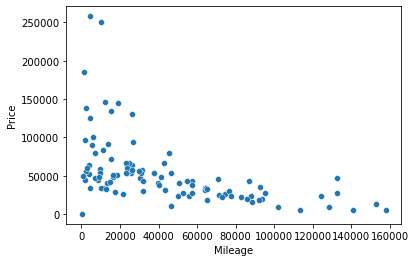

In [58]:
#Plot Mileage v. Price:
sns.scatterplot(data['Mileage'], data['Price'])

/Users/edwardguevel/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


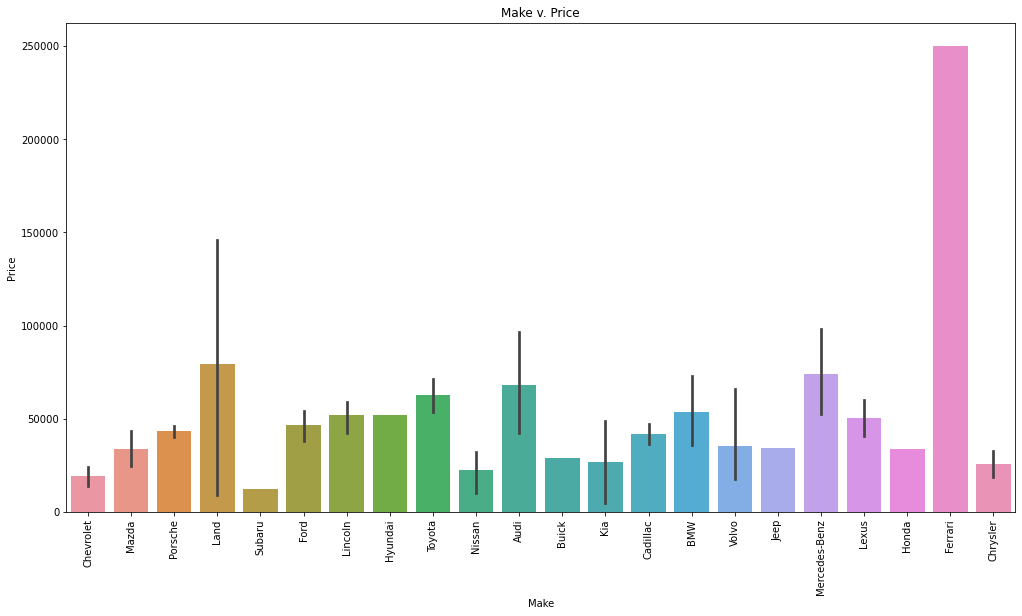

In [60]:

fig, ax = plt.subplots(figsize=(17,9 ))
sns.barplot(data['Make'], data['Price'], ax=ax)
ax.set_title('Make v. Price')
ax.set_xlabel('Make')
ax.set_ylabel('Price')
plt.xticks(rotation=90)
plt.show()

In [51]:
#re.findall(year_regex, data['Name'][0])
data['Name'][0]

re.findall(year_regex, '2012 Chevrolet Suburban 1500 LTZ')
data['Make'].unique()

array(['Chevrolet', 'Mazda', 'Porsche', None, 'Land', 'Subaru', 'Ford',
       'Lincoln', 'Hyundai', 'Toyota', 'Nissan', 'Audi', 'Buick', 'Kia',
       'Cadillac', 'BMW', 'Volvo', 'Jeep', 'Mercedes-Benz', 'Lexus',
       'Honda', 'Ferrari', 'Chrysler'], dtype=object)

In [72]:
#Generate a Rating Function:

#Compute average price for each make:
#avg_make_price = movie.movie_title.str.len().groupby([movie.years, movie.Action]).mean()
avg_make_price = data.Price.groupby(data.Make).mean()
#print(avg_make_price)
#avg_make_price['Ford']

#Function for computing comparative rating:
def rating(df):
    for m in makes:
        if df['Make']==m:
            return df['Price']/avg_make_price[m]/(df['Mileage']/10000)*(int(df['Year'])/1000)
    
    return None
    #return df['Price']/avg_make_price[]

data['Rating'] = data.apply(rating, axis=1)    

data

#data['Price'][0]/avg_make_price['Chevrolet']*(data['Mileage'][0]/100000)*(int(data['Year'][0])/1000)

,Mileage,Price,Make,Year,Model,Rating
0,123962,23387,Chevrolet,2012,Suburban 1500 LTZ,0.195447
1,10918,33679,Mazda,2020,MX-5 Miata RF Grand Touring,1.846852
2,57119,42994,Porsche,2006,911 Carrera,0.347038
3,95332,27999,None,2015,None,NaN
4,12268,145998,Land,2022,Rover Range Rover Sport SVR Carbon Edition,3.033871
...,...,...,...,...,...,...
97,26405,57168,BMW,2019,X6 xDrive35i,0.816617
98,77512,22975,Chevrolet,2012,Suburban 1500 Commercial Fleet,0.307064
99,92794,34995,Nissan,2018,NV Cargo NV2500 HD SV V6/SV V8,0.340582
100,65080,32699,Chrysler,2017,Pacifica Hybrid Platinum,0.395122
